In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd

In [8]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

Text(0.5, 0, 'Date')

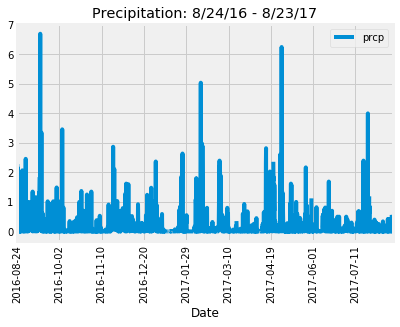

In [16]:
# Query for the latest date
lastdate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

# Convert latest date to usable string and separate year, month, date
lastdate = list(lastdate)[0]
lastdate = dt.datetime.strptime(lastdate, '%Y-%m-%d')

year = int(dt.datetime.strftime(lastdate, '%Y'))
month = int(dt.datetime.strftime(lastdate, '%m'))
day = int(dt.datetime.strftime(lastdate, '%d'))

# From latest date, calculate date one year ago
yearbefore = dt.date(year, month, day) - dt.timedelta(days=365)

# Query for rain data in the last year
rain_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearbefore)
                  .order_by(Measurement.date.asc())
                  .all())

# Convert data to pandas dataframe
rain_df = pd.DataFrame(rain_data)
rain_df.dropna()
rain_df = rain_df.set_index('date')

# Plot data in a bar plot 
rainplot = rain_df.plot(title="Precipitation: 8/24/16 - 8/23/17", rot=90)
rainplot.set_xlabel("Date",fontsize=12)


In [17]:
# Calculate summary statistics for precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [61]:
# Query to find number of stations
stationscount = session.query(Station).count()
print([stationscount])

[9]


In [62]:
# Query for most active stations (i.e. what stations have the most rows)
stationcount = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationcount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Set most action station 
most_active_station = stationcount[0][0]

# Query for station name
stationname = (session.query(Station.name)
                      .filter_by(station = most_active_station))
stationname = stationname[0][0]

# Query for highest temperature
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == most_active_station)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]

# Query for lowest temperature
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == most_active_station)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]

# Query for average temperature
averagetemp =  (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == most_active_station))
averagetemp= '{0:.3}'.format(averagetemp[0][0])

print(f"Most Active Station: {most_active_station} {stationname}")
print(f" Highest Temp Recorded There: {highestTemp}")
print(f" Lowest Temp Recorded There: {lowestTemp}")
print(f"Average Temp Recorded There: {averagetemp}")

Most Active Station: USC00519281 WAIHEE 837.5, HI US
 Highest Temp Recorded There: 85.0
 Lowest Temp Recorded There: 54.0
Average Temp Recorded There: 71.7


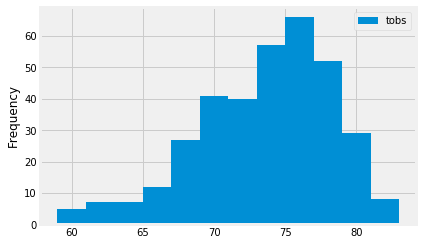

In [66]:
# Query for the last year of temperature data at most active station
temp_data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearbefore)
                   .filter(Measurement.station == most_active_station)
                   .order_by(Measurement.date)
                   .all())

# Convert query to data frame
temp_df = pd.DataFrame(temp_data)
temp_df = temp_df.set_index('date')

# Sort by date
temp_df = temp_df.sort_index(ascending=True)

# Plot histogram using Pandas
temp_df.plot(kind='hist', bins=12)

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
#set trip dates and previous dates
trip = '2019-10-04 to \n 2019-10-11'
trip_start_date = '2016-10-04'
trip_end_date = '2016-10-11'

#calculate the tmin, tavg, and tmax 
trip_temps = calc_temps(trip_start_date, trip_end_date)

trip_temps

[(71.0, 77.43137254901961, 82.0)]

Text(0, 0.5, 'Temp (F)')

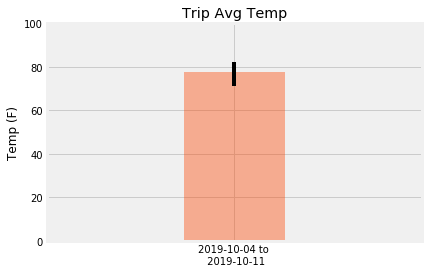

In [70]:
# Separate tmin, tavg, and tmax
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

# Use peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_error = avg_temp - min_temp
max_eror = max_temp - avg_temp

error_bars = np.array([[min_error], [max_eror]])

# Plot bar chart using Matplotlib
plt.bar (trip,avg_temp, yerr=error_bars, color = 'orangered', alpha = .4)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

In [71]:
# Query for precipitation per station on trip dates
precipitation_per_station = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain_data = (session.query(*precipitation_per_station)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start_date)
                   .filter(Measurement.date <= trip_end_date)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

# Convert query to Pandas data frame
station_rain_data = pd.DataFrame(np.array(station_rain_data))

#rename columns
station_rain_data = station_rain_data.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

station_rain_data

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.709999999999999,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.32,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.07,21.4234,-157.8015,14.6
3,USC00517948,"PEARL CITY, HI US",0.07,21.3934,-157.9751,11.9
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.04,21.5213,-157.8374,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",0.0,21.2716,-157.8168,3.0
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.0,21.33556,-157.71139,19.5


## Optional Challenge Assignment

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [94]:
# Set start and end date for the trip
start_date = "2019-10-04"
end_date = "2019-10-11"

# Calculate trip length
start_number = int(start_date[-2:])
end_number = int(end_date[-2:])
trip_length = end_number - start_number + 1

# Convert start date to datetime object
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

# List dates as month, date format 
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, trip_length)]

# Calculate normals for each date
trip_normals = []
for date in date_list:
    trip_normals.append(daily_normals(date)) 
    
trip_normals

[[(67.0, 75.86274509803921, 82.0)],
 [(67.0, 76.16666666666667, 84.0)],
 [(70.0, 75.42, 81.0)],
 [(68.0, 75.6078431372549, 81.0)],
 [(66.0, 76.3265306122449, 86.0)],
 [(69.0, 76.11363636363636, 84.0)],
 [(69.0, 75.85416666666667, 83.0)],
 [(69.0, 76.57142857142857, 84.0)]]

In [104]:
#convert normals list into a data frame
normals_table = pd.DataFrame(trip_normals)

#add date column
normals_table["Date"] = date_list

#set index and rename columns
normals_table = normals_table.set_index("Date")
normals_table = normals_table.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normals_table

,Low Temp,Avg Temp,High Temp
Date,,,
10-04,67.0,75.862745,82.0
10-05,67.0,76.166667,84.0
10-06,70.0,75.420000,81.0
10-07,68.0,75.607843,81.0
10-08,66.0,76.326531,86.0
10-09,69.0,76.113636,84.0
10-10,69.0,75.854167,83.0
10-11,69.0,76.571429,84.0


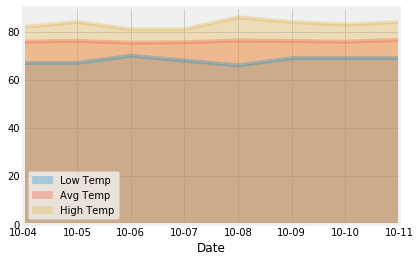

In [105]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.3)